In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Cargando dataset

In [2]:
# Lista de los valores únicos

df=pd.read_csv("../data/interim/modelado_FINAL.csv")

df.columns

Index(['id', 'title', 'location_area', 'company_display_name', 'contract_time',
       'salary_min', 'salary_max', 'salary_is_predicted', 'created',
       'latitude', 'longitude', 'redirect_url', 'description_full', 'remote',
       'permanent_contract', 'freelance', 'bonuses', 'career_development',
       'immediate_start', 'startup', 'multinational',
       'consulting_or_outsourcing', 'experience_gt_5', 'intern', 'junior',
       'senior', 'lead', 'principal_or_manager', 'higher_education',
       'certifications_required', 'software_development', 'data_science_ml',
       'cybersecurity', 'qa_testing', 'it_support_infrastructure',
       'project_product_management', 'ux_ui_design'],
      dtype='object')

### Eliminar información muy irrelevante

En este caso borramos la columna de si el salario es una predicción de la plataforma de la que obtenemos los salarios

In [3]:
columns_to_drop = ['salary_is_predicted']
df = df.drop(columns=columns_to_drop)

Borramos ofertas cuyo título desvirtúa el dataset

In [4]:
# Lista de patrones que indican que NO es una oferta real de empleo
exclusion_keywords = [
    "paid market research",
    "research study",
    "study for",
    "60min",
    "participate in",
    "compensated interview",
    "survey study",
    "market research session"
]

# Convertir el título a minúsculas para asegurar coincidencias
df["title_clean"] = df["title"].fillna("").str.lower()

# Crear una máscara para detectar si alguna de esas frases aparece en el título
pattern = '|'.join(exclusion_keywords)
mask_fake_offers = df["title_clean"].str.contains(pattern, regex=True)

# Eliminar esas filas
df = df[~mask_fake_offers].copy()

# Limpiar la columna auxiliar si no la necesitas
df.drop(columns=["title_clean"], inplace=True)


In [5]:
df.shape

(74357, 36)

## Obtención de seniorities del título del trabajo
Para complementar el modelo zero-shot aplicado y conseguir mejores resultados

In [6]:
# Paso 1: Definir patrones regex por nivel de seniority (con prioridad)
seniority_regex = [
    ("cto", r"\b(?:cto|chief technology officer)\b"),
    ("principal_or_manager", r"\b(?:principal|manager)\b"),
    ("lead", r"\blead\b"),
    ("senior", r"\b(?:senior|sr)\b"),
    ("junior", r"\b(?:junior|jr)\b"),
    ("intern", r"\b(?:intern|trainee|internship|apprentice)\b")
]

# Paso 2: Asegurar que 'title' esté en minúsculas y sin NaNs
df["title"] = df["title"].fillna("").str.lower()

# Paso 3: Crear columnas auxiliares *_title para detección con regex
for level, pattern in seniority_regex:
    df[level + "_title"] = df["title"].str.contains(pattern, regex=True, na=False).astype(int)

# Paso 4: Asegurar que las columnas reales existen (crear 'cto' si hace falta)
for level, _ in seniority_regex:
    if level not in df.columns:
        df[level] = 0

# Paso 5: Si *_title es 1, sustituir la columna real por 1
for level, _ in seniority_regex:
    df.loc[df[level + "_title"] == 1, level] = 1

# Paso 6: Eliminar las columnas *_title
df.drop(columns=[level + "_title" for level, _ in seniority_regex], inplace=True)

# Paso 7: Crear la columna 'seniority' según prioridad
df['seniority'] = 'unknown'
for level, _ in seniority_regex:
    df.loc[(df[level] == 1) & (df['seniority'] == 'unknown'), 'seniority'] = level



In [7]:
columns_to_drop = ["cto"]
df.drop(columns=columns_to_drop)

,id,title,location_area,company_display_name,contract_time,salary_min,salary_max,created,latitude,longitude,...,higher_education,certifications_required,software_development,data_science_ml,cybersecurity,qa_testing,it_support_infrastructure,project_product_management,ux_ui_design,seniority
0,5172667476,it infrastructure administrator,"US, Ohio, Franklin County, Grandview Heights",Experis,NaN,92562.85,92562.85,2025-05-01T06:17:44Z,39.991073,-83.000202,...,0.032945,0.353574,0.513744,0.176900,0.197202,0.227965,0.310890,0.820510,0.404728,unknown
1,5043698107,it program manager,"US, Massachusetts, Middlesex County, Marlborough",BJ's Wholesale Club,NaN,106284.47,106284.47,2025-02-09T06:17:30Z,42.346740,-71.550240,...,0.312562,0.504661,0.276124,0.329195,0.045312,0.022307,0.027231,0.378242,0.081963,principal_or_manager
2,5172667443,it operations window engineer,"US, New York, Orange County, Chester",Experis,full_time,107743.86,107743.86,2025-05-01T06:17:44Z,41.353013,-74.263700,...,0.059313,0.796602,0.633942,0.427687,0.490027,0.857570,0.436988,0.556164,0.473490,unknown
3,5172673565,senior it business systems analyst,"US, Wisconsin, Kenosha County, Trevor","Uline, Inc.",full_time,118673.77,118673.77,2025-05-01T06:19:53Z,42.516405,-88.132486,...,0.714006,0.659511,0.807941,0.362978,0.142299,0.338205,0.247681,0.854075,0.280981,senior
4,5172673330,senior it business systems analyst,"US, Wisconsin, Racine County, Burlington","Uline, Inc.",full_time,112896.08,112896.08,2025-05-01T06:19:49Z,42.662802,-88.276015,...,0.601669,0.767332,0.839628,0.171539,0.031274,0.057170,0.125325,0.546452,0.247142,senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75005,5152643894,software engineer iii,"US, Ohio, Greene County, Riverside",Voyager Space Holdings,full_time,109000.00,130000.00,2025-04-18T23:48:08Z,39.763933,-84.088827,...,0.578739,0.765566,0.977161,0.395482,0.448740,0.150237,0.201217,0.646336,0.234824,unknown
75006,5168157112,cyber analyst - threat intelligence,"US, Ohio, Auglaize County, New Bremen",Crown Equipment Corporation,NaN,100280.55,100280.55,2025-04-29T03:51:05Z,40.436992,-84.379673,...,0.277776,0.568216,0.211755,0.284250,0.635303,0.102045,0.234250,0.487559,0.122390,unknown
75007,5046610235,"pharma & life sciences veeva team, senior manager","US, Ohio, Cuyahoga County, Newburgh Heights",PwC,NaN,136017.45,136017.45,2025-02-11T18:53:42Z,41.493070,-81.668320,...,0.660612,0.969423,0.941225,0.883411,0.873030,0.954993,0.935115,0.961505,0.950420,principal_or_manager
75008,5147030478,documentum developer,"US, Ohio, Franklin County, Columbus",FlightSafety International,NaN,101160.50,101160.50,2025-04-16T04:42:43Z,40.103832,-83.020025,...,0.631620,0.839380,0.825707,0.362999,0.167612,0.400507,0.448072,0.822380,0.317238,unknown


## Creando la columna "salary_avg"

Se eliminan los salarios con datos muy bajos que pueden distorsionar la media

In [8]:
df = df.drop(df[(df["salary_min"] <= 10000) | (df["salary_max"] <= 10000)].index)

In [9]:
# Crear la columna salary_avg como media de salary_min y salary_max
df["salary_avg"] = df[["salary_min", "salary_max"]].mean(axis=1)


## Limpiando seniorities y reduciendo columnas

### Obtención de media salarial de cada seniority

In [10]:
salary_by_seniority = (
    df[df['seniority'] != 'unknown']
    .groupby('seniority')['salary_avg']
    .median()
    .to_dict()
)
salary_by_seniority

{'cto': 121482.24,
 'intern': 55893.42,
 'junior': 72500.0,
 'lead': 118828.235,
 'principal_or_manager': 130999.795,
 'senior': 122089.845}

In [11]:
df

,id,title,location_area,company_display_name,contract_time,salary_min,salary_max,created,latitude,longitude,...,software_development,data_science_ml,cybersecurity,qa_testing,it_support_infrastructure,project_product_management,ux_ui_design,cto,seniority,salary_avg
0,5172667476,it infrastructure administrator,"US, Ohio, Franklin County, Grandview Heights",Experis,NaN,92562.85,92562.85,2025-05-01T06:17:44Z,39.991073,-83.000202,...,0.513744,0.176900,0.197202,0.227965,0.310890,0.820510,0.404728,0,unknown,92562.85
1,5043698107,it program manager,"US, Massachusetts, Middlesex County, Marlborough",BJ's Wholesale Club,NaN,106284.47,106284.47,2025-02-09T06:17:30Z,42.346740,-71.550240,...,0.276124,0.329195,0.045312,0.022307,0.027231,0.378242,0.081963,0,principal_or_manager,106284.47
2,5172667443,it operations window engineer,"US, New York, Orange County, Chester",Experis,full_time,107743.86,107743.86,2025-05-01T06:17:44Z,41.353013,-74.263700,...,0.633942,0.427687,0.490027,0.857570,0.436988,0.556164,0.473490,0,unknown,107743.86
3,5172673565,senior it business systems analyst,"US, Wisconsin, Kenosha County, Trevor","Uline, Inc.",full_time,118673.77,118673.77,2025-05-01T06:19:53Z,42.516405,-88.132486,...,0.807941,0.362978,0.142299,0.338205,0.247681,0.854075,0.280981,0,senior,118673.77
4,5172673330,senior it business systems analyst,"US, Wisconsin, Racine County, Burlington","Uline, Inc.",full_time,112896.08,112896.08,2025-05-01T06:19:49Z,42.662802,-88.276015,...,0.839628,0.171539,0.031274,0.057170,0.125325,0.546452,0.247142,0,senior,112896.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75005,5152643894,software engineer iii,"US, Ohio, Greene County, Riverside",Voyager Space Holdings,full_time,109000.00,130000.00,2025-04-18T23:48:08Z,39.763933,-84.088827,...,0.977161,0.395482,0.448740,0.150237,0.201217,0.646336,0.234824,0,unknown,119500.00
75006,5168157112,cyber analyst - threat intelligence,"US, Ohio, Auglaize County, New Bremen",Crown Equipment Corporation,NaN,100280.55,100280.55,2025-04-29T03:51:05Z,40.436992,-84.379673,...,0.211755,0.284250,0.635303,0.102045,0.234250,0.487559,0.122390,0,unknown,100280.55
75007,5046610235,"pharma & life sciences veeva team, senior manager","US, Ohio, Cuyahoga County, Newburgh Heights",PwC,NaN,136017.45,136017.45,2025-02-11T18:53:42Z,41.493070,-81.668320,...,0.941225,0.883411,0.873030,0.954993,0.935115,0.961505,0.950420,0,principal_or_manager,136017.45
75008,5147030478,documentum developer,"US, Ohio, Franklin County, Columbus",FlightSafety International,NaN,101160.50,101160.50,2025-04-16T04:42:43Z,40.103832,-83.020025,...,0.825707,0.362999,0.167612,0.400507,0.448072,0.822380,0.317238,0,unknown,101160.50


In [12]:
seniority_cols = ['intern', 'junior','senior', 'lead', 'principal_or_manager']

# Solo modificar filas donde 'seniority' es 'unknown'
mask = df['seniority'] == 'unknown'

# Asignar la columna con el mayor score solo en esas filas
df.loc[mask, 'seniority'] = df.loc[mask, seniority_cols].idxmax(axis=1)



In [13]:
salary_by_seniority = (
    df[df['seniority'] != 'unknown']
    .groupby('seniority')['salary_avg']
    .median()
    .to_dict()
)
salary_by_seniority

{'cto': 121482.24,
 'intern': 63056.41,
 'junior': 78535.91500000001,
 'lead': 103014.45,
 'principal_or_manager': 119723.95999999999,
 'senior': 110845.05}

In [14]:
df.drop(columns=['intern', 'junior', 'lead', 'principal_or_manager', 'senior', 'cto'], inplace=True)

In [15]:
df.columns

Index(['id', 'title', 'location_area', 'company_display_name', 'contract_time',
       'salary_min', 'salary_max', 'created', 'latitude', 'longitude',
       'redirect_url', 'description_full', 'remote', 'permanent_contract',
       'freelance', 'bonuses', 'career_development', 'immediate_start',
       'startup', 'multinational', 'consulting_or_outsourcing',
       'experience_gt_5', 'higher_education', 'certifications_required',
       'software_development', 'data_science_ml', 'cybersecurity',
       'qa_testing', 'it_support_infrastructure', 'project_product_management',
       'ux_ui_design', 'seniority', 'salary_avg'],
      dtype='object')

## Dividiendo location_area

Dividimos el location area en `state`, `county` y `city`

In [16]:
df["location_area"]

0            US, Ohio, Franklin County, Grandview Heights
1        US, Massachusetts, Middlesex County, Marlborough
2                    US, New York, Orange County, Chester
3                   US, Wisconsin, Kenosha County, Trevor
4                US, Wisconsin, Racine County, Burlington
                               ...                       
75005                  US, Ohio, Greene County, Riverside
75006               US, Ohio, Auglaize County, New Bremen
75007         US, Ohio, Cuyahoga County, Newburgh Heights
75008                 US, Ohio, Franklin County, Columbus
75009             US, Ohio, Montgomery County, Miamisburg
Name: location_area, Length: 74126, dtype: object

In [17]:
# Eliminar 'US, ' de la columna location_area
df['location_area'] = df['location_area'].str.replace('US, ', '', regex=False)

# Dividir la columna location_area en partes, separadas por comas
split_location = df['location_area'].str.split(',', expand=True)

# Asegurarse de que las filas con menos de tres partes tengan valores NaN o None
split_location = split_location.rename(columns={0: 'state', 1: 'county', 2: 'city'})

# Limpiar los espacios en blanco en cada nueva columna
split_location['state'] = split_location['state'].str.strip()
split_location['county'] = split_location['county'].str.strip()
split_location['city'] = split_location['city'].str.strip()

# Reemplazar valores vacíos con None
split_location['state'] = split_location['state'].replace('', None)
split_location['county'] = split_location['county'].replace('', None)
split_location['city'] = split_location['city'].replace('', None)

# Unir las columnas resultantes de nuevo al dataframe original
df = df.join(split_location)



In [18]:
df = df.drop('location_area', axis=1)

In [19]:
df["state"] = df["state"].replace("US", "unknown")

In [20]:
df["state"].describe()

count       74126
unique         50
top       Florida
freq         7763
Name: state, dtype: object

## Aplicando thresholds
Con el fin de mejorar después las predicciones, establecemos unos límites a partir de los cuales una columna es "Sí" (1) o "No" (0)

In [21]:
df.describe()

,id,salary_min,salary_max,latitude,longitude,remote,permanent_contract,freelance,bonuses,career_development,...,higher_education,certifications_required,software_development,data_science_ml,cybersecurity,qa_testing,it_support_infrastructure,project_product_management,ux_ui_design,salary_avg
count,7.412600e+04,74111.000000,73917.000000,70528.000000,70528.000000,74126.000000,74126.000000,74126.000000,74126.000000,74126.000000,...,74126.000000,74126.000000,74126.000000,74126.000000,74126.000000,74126.000000,74126.000000,74126.000000,74126.000000,74111.000000
mean,5.096071e+09,111745.619686,116338.467113,37.576971,-92.800680,0.632549,0.650411,0.437475,0.715952,0.926099,...,0.581878,0.756809,0.638374,0.574158,0.556884,0.576491,0.671840,0.764052,0.580530,114033.362849
std,1.395655e+08,41216.965013,45851.772610,6.142618,17.999662,0.281814,0.270225,0.306791,0.212235,0.101636,...,0.267144,0.213176,0.287715,0.288730,0.305866,0.289549,0.262236,0.186045,0.326153,42671.412582
min,1.184900e+09,11700.000000,13000.000000,-14.273095,-170.703054,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12350.000000
25%,5.087194e+09,82904.900000,84908.620000,33.755711,-105.942534,0.395375,0.455979,0.135058,0.560601,0.913832,...,0.383956,0.637349,0.439570,0.322577,0.289943,0.331430,0.484929,0.645789,0.259903,84302.305000
50%,5.138930e+09,109195.270000,111698.230000,37.694842,-84.949888,0.701611,0.720649,0.423714,0.765578,0.964444,...,0.612575,0.821810,0.731030,0.651113,0.636078,0.648737,0.756997,0.815316,0.687317,110652.620000
75%,5.162001e+09,136589.280000,140844.470000,41.046764,-78.892044,0.881757,0.886707,0.715173,0.895212,0.987215,...,0.805589,0.930509,0.874840,0.824988,0.821391,0.827199,0.889483,0.917671,0.877197,138893.545000
max,5.174931e+09,450000.000000,600000.000000,71.300340,-66.567142,0.999899,0.999791,0.999674,0.999732,0.999954,...,0.999686,0.999776,0.999789,0.999635,0.999596,0.999718,0.999838,0.999763,0.999606,500000.000000


In [22]:
thresholds = {
    'remote': 0.8,
    'permanent_contract': 0.6,
    'freelance': 0.8,
    'bonuses': 0.5,
    'career_development': 0.6,
    'immediate_start': 0.7,
    'startup': 0.5,
    'multinational': 0.6,
    'consulting_or_outsourcing': 0.6,
    'experience_gt_5': 0.7,
    'higher_education': 0.7,
    'certifications_required': 0.7,
    'software_development': 0.6,
    'data_science_ml': 0.7,
    'cybersecurity': 0.6,
    'qa_testing': 0.5,
    'it_support_infrastructure': 0.6,
    'project_product_management': 0.7,
    'ux_ui_design': 0.6
}

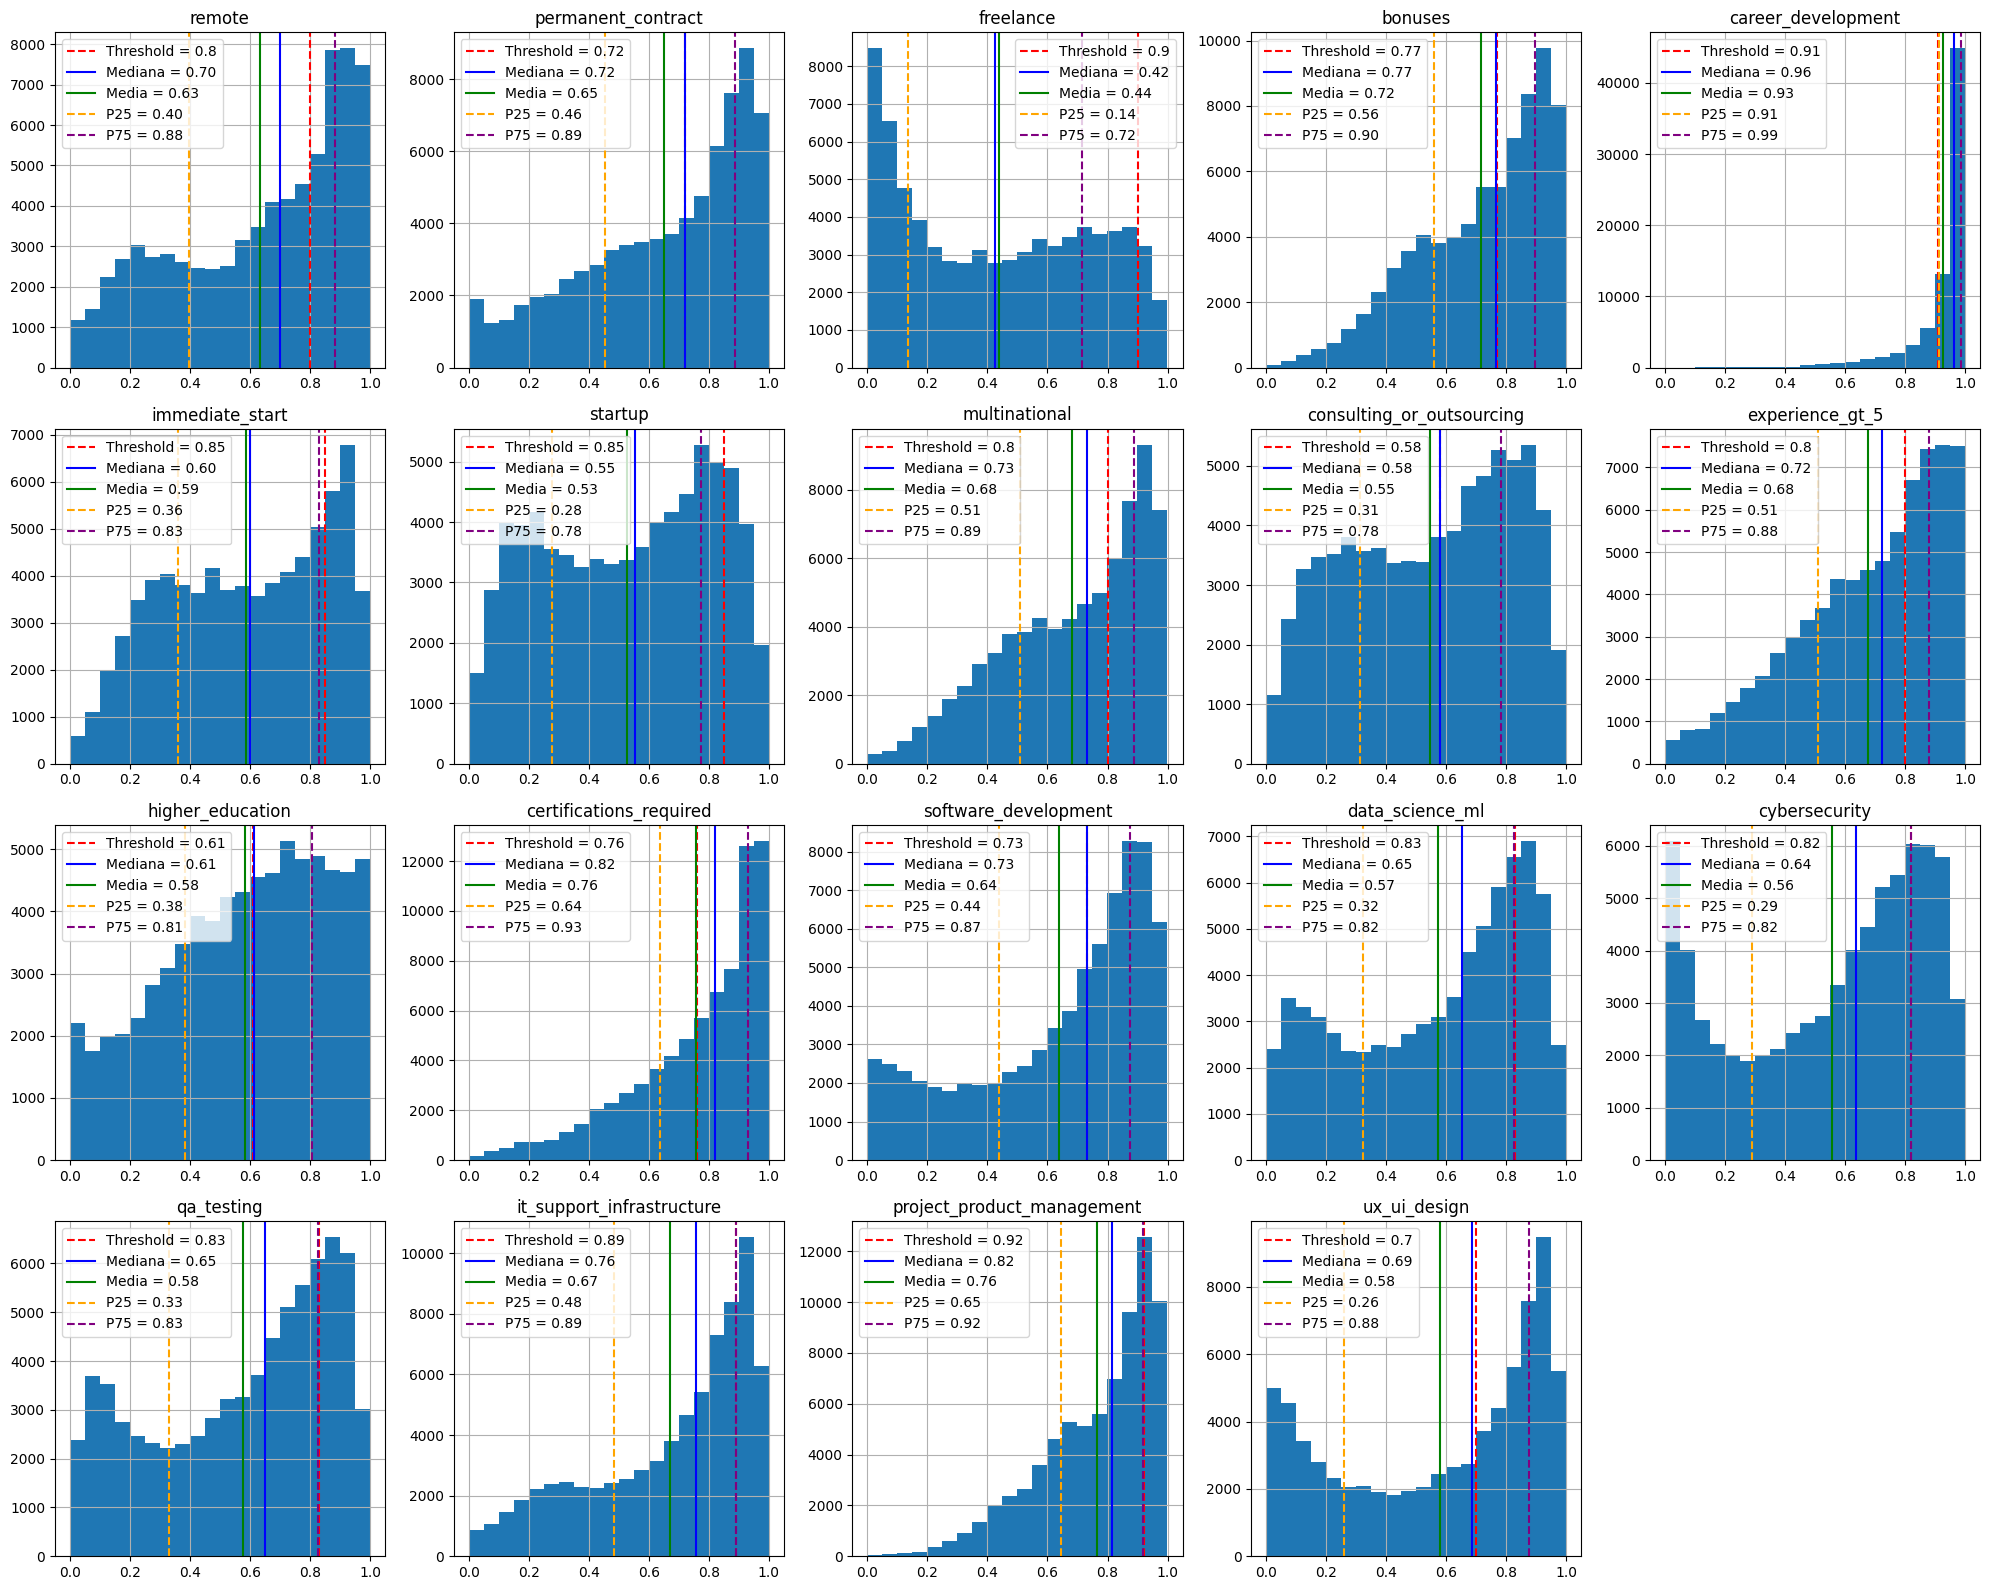

In [29]:
# Agregar líneas para media, percentil 25 y 75, además de mediana y threshold

cols_per_row = 5
rows = math.ceil(len(thresholds) / cols_per_row)

fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(20, rows * 4))
axes = axes.flatten()

for idx, (col, thr) in enumerate(thresholds.items()):
    ax = axes[idx]
    df[col].hist(ax=ax, bins=20)
    
    # Threshold
    ax.axvline(x=thr, color='red', linestyle='--', label=f'Threshold = {thr}')
    
    # Estadísticas
    median_val = df[col].median()
    mean_val = df[col].mean()
    q25 = df[col].quantile(0.25)
    q50 = df[col].quantile(0.50)
    q75 = df[col].quantile(0.75)
    

    ax.axvline(x=median_val, color='blue', linestyle='-', label=f'Mediana = {median_val:.2f}')
    ax.axvline(x=mean_val, color='green', linestyle='-', label=f'Media = {mean_val:.2f}')
    ax.axvline(x=q25, color='orange', linestyle='--', label=f'P25 = {q25:.2f}')
    ax.axvline(x=q75, color='purple', linestyle='--', label=f'P75 = {q75:.2f}')

    ax.set_title(col)
    ax.legend()

# Ocultar subplots vacíos
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()




In [25]:
thresholds = {
    'remote': 0.8,
    'permanent_contract': 0.72,
    'freelance': 0.9,
    'bonuses': 0.77,
    'career_development': 0.91,
    'immediate_start': 0.85,
    'startup': 0.85,
    'multinational': 0.8,
    'consulting_or_outsourcing': 0.58,
    'experience_gt_5': 0.8,
    'higher_education': 0.61,
    'certifications_required': 0.76,
    'software_development': 0.73,
    'data_science_ml': 0.83,
    'cybersecurity': 0.82,
    'qa_testing': 0.83,
    'it_support_infrastructure': 0.89,
    'project_product_management': 0.92,
    'ux_ui_design': 0.7
}

In [26]:
keywords_desc = {
    'remote': ['remote', 'work from home', 'working remotely'],
    'permanent_contract': ['permanent', 'full-time', 'full time', 'ongoing contract'],
    'freelance': ['freelance', 'self-employed', 'independent consultant'],
    'bonuses': ['bonus', 'bonuses', 'performance bonus', 'benefits', 'incentives'],
    'career_development': ['career development', 'career growth', 'training program', 'development opportunities', 'learning path'],
    'immediate_start': ['immediate start', 'start immediately'],
    'startup': ['startup', 'start-up', 'early-stage company'],
    'multinational': ['multinational', 'global company', 'international company'],
    'consulting_or_outsourcing': ['consulting', 'consultancy', 'outsourcing', 'external projects'],
    'experience_gt_5': ['5+ years', '5 years of experience', 'more than 5 years', 'extensive experience'],
    'higher_education': ['bachelor', 'university degree', 'academic degree'],
    'certifications_required': ['certification required', 'certifications required'],
    'software_development': ['development role'],
}


In [ ]:
keywords_title= {
    'data_science_ml': ['data science', 'data scientist', 'machine learning', 'ml engineer', 'artificial intelligence'],
    'cybersecurity': ['cybersecurity', 'security analyst', 'information security', 'network security'],
    'qa_testing': ['quality assurance', 'test engineer', "qa"],
    'it_support_infrastructure': ['it support', 'technical support', 'helpdesk', 'infrastructure engineer', 'system admin'],
    'project_product_management': ['project manager', 'product manager', 'product owner', 'scrum master', 'product designer'],
    'ux_ui_design': ['ux designer', 'user experience designer', 'ui designer', 'user interface designer', 'ux/ui designer'],
}

In [ ]:
# Asegurar texto limpio en minúsculas y sin NaNs
df["title"] = df["title"].fillna("").str.lower()
df["description_full"] = df["description_full"].fillna("").str.lower()

# Buscar en title
for col, patterns in keywords_title.items():
    pattern_regex = '|'.join([rf'\b{p}\b' for p in patterns])
    df.loc[df["title"].str.contains(pattern_regex, regex=True), col] = 1

# Buscar en description_full
for col, patterns in keywords_desc.items():
    pattern_regex = '|'.join([rf'\b{p}\b' for p in patterns])
    df.loc[df["description_full"].str.contains(pattern_regex, regex=True), col] = 1


In [ ]:
# Incompatibilidad startup vs multinational
if 'startup' in df.columns and 'multinational' in df.columns:
    df.loc[df['startup'] == 1, 'multinational'] = 0

In [ ]:
exclusive_group = [
    'ux_ui_design', 'software_development', 'data_science_ml',
    'cybersecurity', 'qa_testing', 'it_support_infrastructure', 'project_product_management'
]

# Filas donde al menos una columna tiene un 1 exacto
mask = (df[exclusive_group] == 1).any(axis=1)

# Para esas filas, forzar a 0 las columnas que no son 1
for col in exclusive_group:
    df.loc[mask & (df[col] != 1), col] = 0


In [ ]:
df_binario = df.copy() 

for column in df.columns:
    threshold = thresholds.get(column, None)  # Obtener el umbral para cada columna
    if threshold is not None:
        df_binario[column] = (df[column] >= threshold).astype(int)

In [ ]:
# Convertir la columna 'created' a tipo datetime
df_binario["created"] = pd.to_datetime(df_binario["created"])

# Extraer solo el año
df_binario["created"] = df_binario["created"].dt.year


In [ ]:
contract_priority = [
    ('freelance', 'freelance'),
    ('intern', 'internship'),
    ('permanent_contract', 'permanent')
]


In [ ]:
# Inicializar contract_time vacía si no existe
if 'contract_time' not in df.columns:
    df_binario['contract_time'] = None

# Aplicar por prioridad: el primero que cumpla sobrescribe
for col, label in contract_priority:
    if col in df.columns:
        df_binario.loc[(df[col] == 1), 'contract_time'] = label


In [ ]:
df_binario.to_csv('../data/interim/dataset_binario.csv', index=False)

In [ ]:
# df["created"].unique